In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

import sys

# Servidor Python
from http.server import BaseHTTPRequestHandler, HTTPServer
import logging
import json

In [2]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, x, y) in model.grid.coord_iter():
        if content == None:
            grid[x][y] = 0
        else:
            if content.car_malfunction == True:
                grid[x][y] = 200
            else:
                grid[x][y] = 100
    return grid

# Simmulación 1

In [22]:
class CarAgent(Agent):
    def __init__(self, unique_id, model, car_malfunction, num_cars_allowed):
        super().__init__(unique_id, model)
        self.velocity = 60
        self.acceleration = 0
        self.brake = 0
        self.sec_distance = 1
        self.intention = self.random.randint(0, 1) #0 left | 1 right
        self.show_intention = False
        self.car_malfunction = car_malfunction
        self.num_cars_allowed = num_cars_allowed
        self.counter = 0
        self.go_forward = False
        self.front_malfunction = False
                   
    def changeLane(self, neighbor):
        neighbor.counter += 1
        neighbor.velocity = 0
        self.show_intention = False
        x, y = self.pos
        self.velocity = 60
        if self.intention == 0:
            if self.model.grid[x - 1][y] == None:
                self.model.grid.move_agent(self, (x - 1, y))
        elif self.intention == 1:
            if self.model.grid[x + 1][y] == None:
                self.model.grid.move_agent(self, (x + 1, y))
            
    def getWaitingCar(self):
        if self.intention == 0:
            waiting_car_pos = (self.pos[0] - 1, self.pos[1] + 1)
        elif self.intention == 1:
            waiting_car_pos = (self.pos[0] + 1, self.pos[1] + 1)
        return waiting_car_pos
    
    def getPassingCar(self):
        if self.pos[0] == 0:
            passing_car = (self.pos[0] + 1, self.pos[1] - 1)
        elif self.pos[0] == 2:
            passing_car = (self.pos[0] - 1, self.pos[1] - 1)
        
        return passing_car
    
    def canPass(self, neighbor):
        if neighbor.show_intention == True:
            intention = neighbor.intention
            carLane = self.pos[0]
            if (intention == 0 and carLane == 0) or (intention == 1 and carLane == 2):
                if self.counter > self.num_cars_allowed:
                    self.velocity = 60
            elif (intention == 0 and carLane == 2) or (intention == 1 and carLane == 0):
                self.velocity = 60
                
    def step(self):
        
        
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        
        if self.car_malfunction == True and self.pos[1] == self.model.grid.height / 2:
            self.velocity = 0
            self.model.accident_occured = True
        elif self.model.accident_occured == True and self.pos[0] == 1 and self.pos[1] == (self.model.grid.height / 2) + 1:
            self.velocity = 0
        elif self.model.accident_occured == True and (self.pos[0] == 0 or self.pos[0] == 2) and self.pos[1] == (self.model.grid.height / 2) + 2:
            self.velocity = 0
        elif self.model.accident_occured == True and (self.pos[0] == 0 or self.pos[0] == 2) and self.pos[1] <= (self.model.grid.height / 2) + 1:
            self.velocity = 60
            
        for neighbor in neighbors:
            if self.pos[0] == 1:
                if neighbor.car_malfunction == True and neighbor.pos[1] == self.pos[1] - 1: 
                    self.front_malfunction = True
                    self.show_intention = True
                    self.velocity = 0
         
        if self.model.accident_occured == True:
            if self.pos[0] == 1 and self.front_malfunction == True:    
                waiting_car_pos = self.getWaitingCar()
                diagonal_car = self.model.grid[waiting_car_pos[0]][waiting_car_pos[1]]
                if diagonal_car != None:
                    if diagonal_car.counter <= diagonal_car.num_cars_allowed:
                        self.changeLane(diagonal_car)
            elif self.pos[0] == 0 or self.pos[0] == 2 :
                passing_car = self.getPassingCar()
                front_passing_car = self.model.grid[passing_car[0]][passing_car[1]]
                if front_passing_car != None and front_passing_car.front_malfunction == True:
                    self.canPass(front_passing_car)
                elif front_passing_car == None and (self.pos[0] == 0 or self.pos[0] == 2):
                    self.velocity = 60

                    
        if self.velocity == 60 and self.model.grid[self.pos[0]][self.pos[1] - 1] == None:
            self.model.grid.move_agent(self, (self.pos[0], self.pos[1] - 1))


In [23]:
def get_positions(model):
    positions = []
    for (content, x, y) in model.grid.coord_iter():
        if content != None:
            car_properties = {"id": content.unique_id, "posx": x, "posy": y, "car_malfunction": content.car_malfunction}
            positions.append(car_properties)
    return json.dumps(positions)

In [24]:
class RoadModel(Model):
    def __init__(self, width, height):
        self.max_velocity = 60
        self.start_time = time.time()
        self.accident_time = datetime.timedelta(seconds=2*60)
        self.schedule = SimultaneousActivation(self)
        self.accident_occured = False
        self.grid = SingleGrid(width, height, False)
        self.id_counter = 0
        self.count_steps = 0
        
        self.datacollector = DataCollector(model_reporters={"Grid":get_grid})
        
    def step(self):
        self.datacollector.collect(self)
        for (content, x, y) in self.grid.coord_iter():
            if content != None and y == 0:
                self.grid.remove_agent(content)
                self.schedule.remove(content)
        
        
        if self.count_steps == 10:
            accidented_car = CarAgent(self.id_counter, self, True, 0)
            x = 1
            y = self.grid.height - 1
            self.grid.place_agent(accidented_car,(x, y))
            self.schedule.add(accidented_car)
            self.id_counter += 1
        else:
            car_spawn = CarAgent(self.id_counter, self, False, self.random.randint(0, 2))
            x = self.random.randint(0, 2)
            y = self.grid.height - 1
            if self.grid[x][y] == None:
                self.grid.place_agent(car_spawn ,(x, y))
                self.schedule.add(car_spawn)
                self.id_counter += 1
        self.count_steps += 1
        self.schedule.step()
        
            
        
        

In [29]:
MAX_ITERATIONS = 300
WIDTH = 3
HEIGHT = 102

start_time = time.time()
model = RoadModel(WIDTH, HEIGHT)
for i in range(MAX_ITERATIONS):
#     print(get_positions(model))
    model.step()
        
print('Tiempo de ejecución: ', str(datetime.timedelta(seconds=(time.time() - start_time))))


Tiempo de ejecución:  0:00:00.339938


In [30]:
all_grid = model.datacollector.get_model_vars_dataframe()
pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(all_grid)

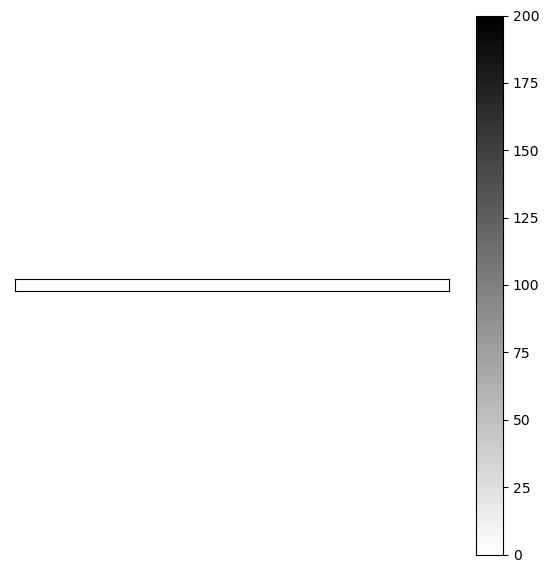

In [31]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])

patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary, vmin=0, vmax=200)
fig.colorbar(patch, ax=axs)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_ITERATIONS)

In [32]:
anim

# Simulación 2

In [ ]:
class CarAgent(Agent):
    def __init__(self, unique_id, model, car_malfunction, num_cars_allowed):
        super().__init__(unique_id, model)
        self.velocity = 60
        self.acceleration = 0
        self.brake = 0
        self.sec_distance = 1
        self.intention = self.random.randint(0, 1) #0 left | 1 right
        self.show_intention = True
        self.car_malfunction = car_malfunction
        self.num_cars_allowed = num_cars_allowed
        self.counter = 0
        self.go_forward = False
        self.front_malfunction = False
                   
    def changeLane(self, neighbor):
        if neighbor != None:
            neighbor.counter += 1
            neighbor.velocity = 0
        self.show_intention = False
        x, y = self.pos
        self.velocity = 60
        if self.intention == 0:
            if self.model.grid[x - 1][y] == None:
                self.model.grid.move_agent(self, (x - 1, y))
        elif self.intention == 1:
            if self.model.grid[x + 1][y] == None:
                self.model.grid.move_agent(self, (x + 1, y))
            
    def getWaitingCar(self):
        if self.intention == 0 and self.pos[1]:
            waiting_car_pos = (self.pos[0] - 1, self.pos[1] + 1)
        elif self.intention == 1 and self.pos[1]:
            waiting_car_pos = (self.pos[0] + 1, self.pos[1] + 1)
        return waiting_car_pos
    
    def getPassingCar(self):
        if self.pos[0] == 0:
            passing_car = (self.pos[0] + 1, self.pos[1] - 1)
        elif self.pos[0] == 2:
            passing_car = (self.pos[0] - 1, self.pos[1] - 1)
        
        return passing_car
    
    def canPass(self, neighbor):
        if neighbor.show_intention == True:
            intention = neighbor.intention
            carLane = self.pos[0]
            if (intention == 0 and carLane == 0) or (intention == 1 and carLane == 2):
                if self.counter > self.num_cars_allowed:
                    self.velocity = 60
            elif (intention == 0 and carLane == 2) or (intention == 1 and carLane == 0):
                self.velocity = 60
                
    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
                
        if self.car_malfunction == True and self.pos[1] == (self.model.grid.height / 2):
            self.velocity = 0
            self.model.accident_occured = True
        elif self.model.accident_occured == True and self.pos[1] <= (self.model.grid.height / 2) + 1:
            self.velocity = 60
        elif self.model.accident_occured == True and (self.pos[0] == 0 or self.pos[0] == 2):
            self.velocity = 0
        
        if self.pos[0] == 1 and self.pos[1] == self.model.grid.height - 5 and self.car_malfunction == False:    
            waiting_car_pos = self.getWaitingCar()
            diagonal_car = self.model.grid[waiting_car_pos[0]][waiting_car_pos[1]]
            if diagonal_car != None:
                if diagonal_car.counter <= diagonal_car.num_cars_allowed:
                    self.changeLane(diagonal_car)
            elif diagonal_car == None:
                self.changeLane(diagonal_car)
        elif self.pos[0] == 0 or self.pos[0] == 2 :
            passing_car = self.getPassingCar()
            front_passing_car = self.model.grid[passing_car[0]][passing_car[1]]
            if front_passing_car != None and front_passing_car.front_malfunction == True:
                self.canPass(front_passing_car)
            elif front_passing_car == None and (self.pos[0] == 0 or self.pos[0] == 2):
                self.velocity = 60
  
        if self.velocity == 60 and self.model.grid[self.pos[0]][self.pos[1] - 1] == None:
            self.model.grid.move_agent(self, (self.pos[0], self.pos[1] - 1))

In [ ]:
class RoadModel(Model):
    def __init__(self, width, height):
        self.max_velocity = 60
        self.start_time = time.time()
        self.accident_time = datetime.timedelta(seconds=2*60)
        self.schedule = SimultaneousActivation(self)
        self.accident_occured = False
        self.grid = SingleGrid(width, height, False)
        self.id_counter = 0
        self.count_steps = 0
        
        self.datacollector = DataCollector(model_reporters={"Grid":get_grid})
        
    def step(self):
        self.datacollector.collect(self)
        for (content, x, y) in self.grid.coord_iter():
            if content != None and y == 0:
                self.grid.remove_agent(content)
                self.schedule.remove(content)
        
        if self.count_steps == 150:
            accidented_car = CarAgent(self.id_counter, self, True, 0)
            x = 1
            y = self.grid.height - 1
            self.grid.place_agent(accidented_car,(x, y))
            self.schedule.add(accidented_car)
            self.id_counter += 1
        else:
            car_spawn = CarAgent(self.id_counter, self, False, self.random.randint(0, 2))
            x = self.random.randint(0, 2)
            y = self.grid.height - 1
            if self.grid[x][y] == None:
                self.grid.place_agent(car_spawn ,(x, y))
                self.schedule.add(car_spawn)
                self.id_counter += 1
        self.count_steps += 1
        self.schedule.step()      

In [ ]:
MAX_ITERATIONS = 300
WIDTH = 3
HEIGHT = 30

start_time = time.time()
model = RoadModel(WIDTH, HEIGHT)
for i in range(MAX_ITERATIONS):
    model.step()
        
print('Tiempo de ejecución: ', str(datetime.timedelta(seconds=(time.time() - start_time))))

In [ ]:
all_grid = model.datacollector.get_model_vars_dataframe()
pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(all_grid)

In [ ]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])

patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary, vmin=0, vmax=200)
fig.colorbar(patch, ax=axs)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_ITERATIONS)

In [ ]:
anim